## MLP - Deep Learning
Un perceptrón multicapa es una red neuronal que tendrá una capa de entrada con un número de entradas (X) igual al número de características, una o más capas intermedias con un número finito de neuronas determinado por experimentación o algún tipo de heurística y una capa de salida con una o más neuronas dependiendo del propósito e la red (Regresión o Clasificación).

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
from sklearn.utils.random import check_random_state
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers,models
import matplotlib.pyplot as plt


### Ejemplo MLP - Deep Learning
Se aplicará un MLP de una sola capa intermedia y otro de 2 capas intermedias para predecir la distancia entre un par de puntos (x,y) y (x1,y1), uno de ellos constante.$$ d = \sqrt{(x1-x)^2 + (y1 - y)^2} $$

### Generar el conjunto de datos
Para generar el conjunto de datos se calculará la distancia entre un conjunto de 5000 puntos (x,y) aleatorios, así, el modelo de regresión se ajustará a una proporción del 80% del conjunto y el 20% restante estará destinado a la predicción.

In [10]:
def calcular_distancia(X,Y,XF,YF):
    return np.round(np.sqrt(np.power(XF-X,2)+np.power(YF-Y,2)),2)

XF = 5
YF = 12.5

rng = check_random_state(0)

X = np.round(rng.uniform(1, 11, 10000).reshape(5000, 2),2)
XFs=[[XF] for i in range(5000)]
YFs=[[YF] for i in range(5000)]
X=np.append(X, XFs, axis=1)
X=np.append(X, YFs, axis=1)
Y = calcular_distancia(X[:, 0],X[:, 1],XF,YF)
Y = Y.reshape(-1,1)

### Configuración de metadatos
Los metadatos son los parámetros de la red, entre ellos:
* La cantidad de neuronas
* La tasa de aprendizaje
* El número de epochs
* El nivel de paciencia para el EarlyStopping

In [2]:
NEURONAS = 90
LEARNING_RATE =0.0001
EPOCHS = 5000
PACIENCIA = 80

### Proceso de transformación
Es una práctica común, en las redes neuronales, normalizar el conjunto de datos de entrenamiento, pues se ha demostrado que las redes neuronales aprenden mejor con valores pequeños entre 0 y 1.

In [11]:
def transformar(X,Y):
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    x_scale = scaler_x.fit_transform(X)
    y_scale = scaler_y.fit_transform(Y)
    return (x_scale,y_scale)

### Construcción del modelo
La construcción del modelo se encarga de definir la arquitectura de la red

In [22]:
def build_model(N,LR):
    model = models.Sequential()
    model.add(layers.Dense(units=N,activation='relu',input_dim=4))
    model.add(layers.Dense(units=N/2,activation='relu'))
    model.add(layers.Dense(units=1,activation='linear'))
    # #cargar checkpoint
    # #model.load_weights("weights.best.hdf5")
    
    model.compile(optimizer= keras.optimizers.Adam(learning_rate=LR), 
                  loss='mean_squared_error',  
                  metrics=['mse',tf.keras.metrics.RootMeanSquaredError(),tf.keras.metrics.MeanAbsoluteError()])
    model.summary()
    return model

### Proceso de entrenamiento, evaluación y validación del modelo
En estos procesos es imprescindible contar con una métrica que permita valorar la precisión del modelo, en este caso, **MSE, RMSE y MAE** son las métricas usadas para tal valoración.

In [23]:
def entrenar_validar(model,x_train,y_train,x_valid,y_valid,x_eval,y_eval):   
    es = keras.callbacks.EarlyStopping(monitor='loss', mode='min', patience=PACIENCIA)
    
    history = model.fit(x_train, y_train, epochs=EPOCHS, validation_data=(x_valid,y_valid),verbose=0,callbacks=[es])
   
    print("ETRENAMIENTO TERMINADO")
    print(history.history.keys())
    print("")
    
    eval_score = evaluar_modelo(model, x_eval, y_eval)
    
    return (history,eval_score)

def evaluar_modelo(model,x_valid,y_valid):
    print("--------------EVALUACION------------------")
    score = model.evaluate(x_valid,y_valid,verbose=1,return_dict=True)
    print('Evaluación '+str(score))
    print("")
    return score

In [24]:
def construir_entrenar_validar():
    x_scale,y_scale = transformar(X, Y)
    x_train, x_test, y_train, y_test = train_test_split(x_scale, y_scale, train_size=0.8, test_size=0.2, random_state=42)
    x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, train_size=0.5, test_size=0.5, random_state=42)
    model = build_model(NEURONAS,LEARNING_RATE)
    history,score = entrenar_validar(model, x_train, y_train, x_test, y_test, x_valid, y_valid) 
    return (model, history,score)

### Gráfica de aprendizaje
Es una forma útil de visualizar el proceso de aprendizaje e identificar fenómenos como el overfetting. 

In [25]:
def graficar(history):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()    

#74 es el numero de modelo que sigue despues de los de la version 5. 
def generar_modelo():
    modelo,history,eval_score = construir_entrenar_validar()
    graficar(history)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 90)                450       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 91        
Total params: 541
Trainable params: 541
Non-trainable params: 0
_________________________________________________________________
ETRENAMIENTO TERMINADO
dict_keys(['loss', 'mse', 'root_mean_squared_error', 'mean_absolute_error', 'val_loss', 'val_mse', 'val_root_mean_squared_error', 'val_mean_absolute_error'])

--------------EVALUACION------------------
16/16 [==============================] - 0s 2ms/step - loss: 7.5207e-07 - mse: 7.5207e-07 - root_mean_squared_error: 8.6722e-04 - mean_absolute_error: 6.4017e-04
Evaluación {'loss': 7.520717417719425e-07, 'mse': 7.520717417719425e-07, 'root_mean_squared_error': 0.0008672206895425916, 'mean_ab

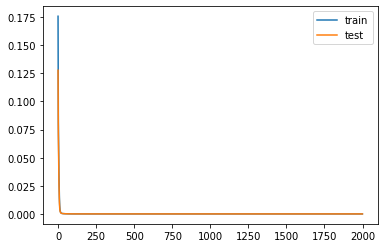

In [21]:
generar_modelo()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 90)                450       
_________________________________________________________________
dense_5 (Dense)              (None, 45)                4095      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 46        
Total params: 4,591
Trainable params: 4,591
Non-trainable params: 0
_________________________________________________________________
ETRENAMIENTO TERMINADO
dict_keys(['loss', 'mse', 'root_mean_squared_error', 'mean_absolute_error', 'val_loss', 'val_mse', 'val_root_mean_squared_error', 'val_mean_absolute_error'])

--------------EVALUACION------------------
16/16 [==============================] - 0s 2ms/step - loss: 7.2014e-07 - mse: 7.2014e-07 - root_mean_squared_error: 8.4861e-04 - mean_absolute_error: 6.6225

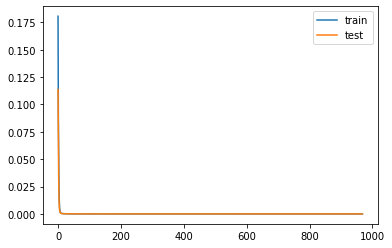

In [26]:
generar_modelo()